# **Phân loại tin tức tiếng Việt sử dụng SVM**

## 1. Xác định bài toán

- Đầu vào bài toán: 1 đoạn tin tức tiếng Việt  
- Đầu ra: Lớp tương ứng với đoạn tin tức đó

- Dataset: VNews8td  
- Mô tả:  Được thu thập từ trang báo mạng VnExpress từ ngày 01/06/2023 - 01/06/2024. Gồm 8 lớp, chia train:val:test theo tỉ lệ 70:10:20. Mỗi văn bản sẽ gồm có tiêu đề và phần mô tả của bài báo  
- 8 lớp: 	
    * doisong (Đời sống)
	* giaoduc (Giáo dục)
	* khoahoc (Khoa học)
	* kinhte (Kinh tế)
	* suckhoe (Sức khỏe)
	* thegioi (Thế giới)
	* thethao (Thể thao)
	* thoisu (Thời sự)

### Import thư viện 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import  ConfusionMatrixDisplay

## 2. Tiền xử lý dữ liệu

In [2]:
train_df = pd.read_csv("VNews8td/train.tsv", sep='\t',header=None, names=['văn bản','lớp'])
test_df = pd.read_csv("VNews8td/test.tsv", sep='\t',header=None, names=['văn bản','lớp'])
val_df = pd.read_csv("VNews8td/val.tsv", sep='\t',header=None, names=['văn bản','lớp'])

In [3]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(31745, 2)
(9115, 2)
(4490, 2)


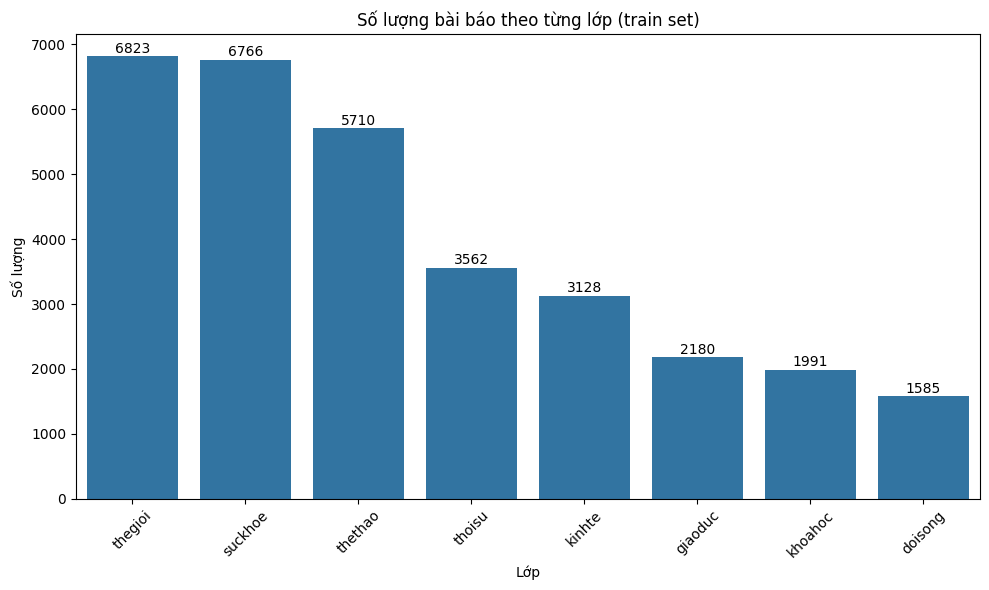

In [4]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_df, x='lớp', order=train_df['lớp'].value_counts().index)

plt.title('Số lượng bài báo theo từng lớp (train set)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5,  
            f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Dữ liệu bị mất cân bằng giữa các lớp --> dùng class weighted, hoặc augment data 

In [5]:
tokens = ViTokenizer.tokenize(train_df['văn bản'][0]).split()
print(tokens)

['Ba_Lan', 'sa_thải', 'HLV', 'Santos', 'sau', 'sáu', 'trận', '.', 'Liên_đoàn', 'Bóng_đá', 'Ba_Lan', 'quyết_định', 'chia_tay', 'HLV', 'Fernando_Santos', ',', 'người', 'từng', 'đưa', 'Bồ_Đào_Nha', 'đến', 'chức', 'vô_địch', 'Euro', '2016', '.']


In [6]:
with open('vietnamese_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = list(line.strip() for line in f)

def preprocess(text):
    tokens = ViTokenizer.tokenize(text).split()
    filtered_tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(filtered_tokens)

txt = preprocess(train_df['văn bản'][0])
print(txt)

Ba_Lan sa_thải HLV Santos sáu trận . Liên_đoàn Bóng_đá Ba_Lan quyết_định chia_tay HLV Fernando_Santos , Bồ_Đào_Nha chức vô_địch Euro 2016 .


In [7]:
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[0:10])

Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']


Ghép các từ tiếng Việt lại và xóa stop words 

In [8]:
train_df['processed'] = train_df['văn bản'].apply(preprocess)
val_df['processed'] = val_df['văn bản'].apply(preprocess)
test_df['processed'] = test_df['văn bản'].apply(preprocess)

In [9]:
train_df['văn bản'][0]

'Ba Lan sa thải HLV Santos sau sáu trận. Liên đoàn Bóng đá Ba Lan quyết định chia tay HLV Fernando Santos, người từng đưa Bồ Đào Nha đến chức vô địch Euro 2016.'

In [10]:
train_df['processed'][0]

'Ba_Lan sa_thải HLV Santos sáu trận . Liên_đoàn Bóng_đá Ba_Lan quyết_định chia_tay HLV Fernando_Santos , Bồ_Đào_Nha chức vô_địch Euro 2016 .'

Chuyển dữ liệu từ dạng văn bản về dạng số để xử lý 

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['processed'])
X_val = vectorizer.transform(val_df['processed'])
X_test = vectorizer.transform(test_df['processed'])


In [12]:
le = LabelEncoder()
y_train = le.fit_transform(train_df['lớp'])
y_val = le.transform(val_df['lớp'])
y_test = le.transform(test_df['lớp'])

In [13]:
labels = le.classes_
print(labels)

['doisong' 'giaoduc' 'khoahoc' 'kinhte' 'suckhoe' 'thegioi' 'thethao'
 'thoisu']


In [ ]:
print("Dữ liệu training: ", X_train.shape, y_train.shape)
print("Dữ liệu validation: ", X_val.shape, y_val.shape)
print("Dữ liệu testing: ", X_test.shape, y_test.shape)

Dữ liệu training:  (31745, 30910) (31745,)
Dữ liệu validation:  (4490, 30910) (4490,)
Dữ liệu testing:  (9115, 30910) (9115,)


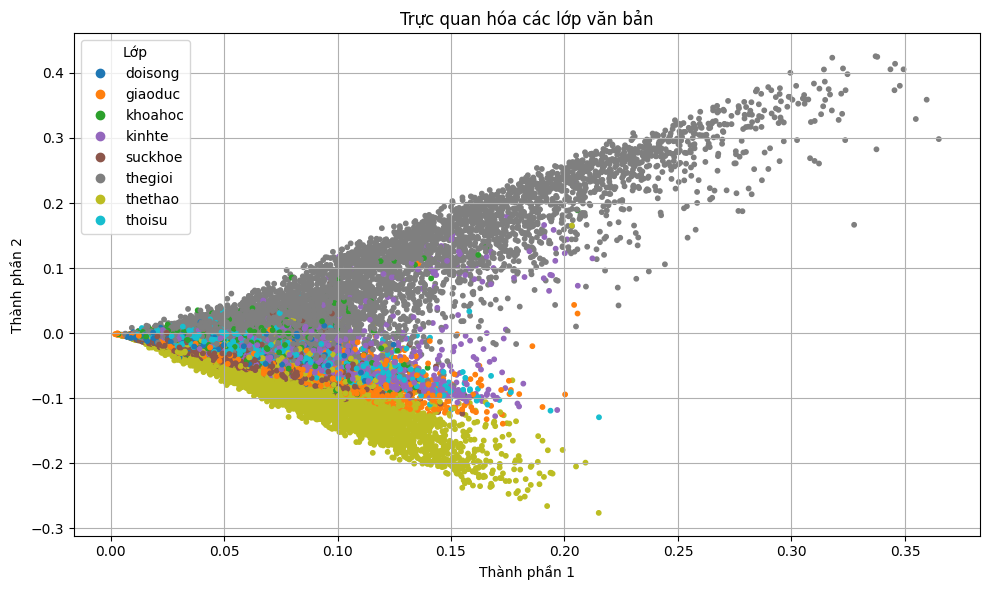

In [ ]:
from sklearn.decomposition import TruncatedSVD
import re

svd = TruncatedSVD(n_components=3, random_state=42)
X_svd = svd.fit_transform(X_train)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_train, cmap='tab10', s=10)

handles, indices = scatter.legend_elements()

legend_labels = [labels[int(re.sub(r"[^\d]", "", i))] for i in indices]
plt.legend(handles, legend_labels, title="Lớp")

plt.title("Trực quan hóa các lớp văn bản")
plt.xlabel("Thành phần 1")
plt.ylabel("Thành phần 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Huấn luyện mô hình & đánh giá mô hình

*Lưu ý: Đánh giá trên tập validation*

### Kernel linear với C=1

In [15]:
print("- Training with kernel linear ...")
print("- Train size = {}".format(X_train.shape))
model_linear = svm.SVC(kernel='linear', C=1)
model_linear.fit(X_train, y_train)
print("- model - train complete")


- Training with kernel linear ...
- Train size = (31745, 30910)
- model - train complete


In [16]:
from sklearn.metrics import confusion_matrix

print("- Testing ...")
y_val_pred = model_linear.predict(X_val)
y_train_pred = model_linear.predict(X_train)
print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

- Testing ...

 Classification Report (Train Set):
              precision    recall  f1-score   support

     doisong       0.95      0.91      0.93      1585
     giaoduc       0.98      0.98      0.98      2180
     khoahoc       0.97      0.97      0.97      1991
      kinhte       0.97      0.97      0.97      3128
     suckhoe       0.98      0.99      0.99      6766
     thegioi       0.99      0.98      0.99      6823
     thethao       0.99      1.00      1.00      5710
      thoisu       0.97      0.97      0.97      3562

    accuracy                           0.98     31745
   macro avg       0.97      0.97      0.97     31745
weighted avg       0.98      0.98      0.98     31745



In [17]:
print("\n Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


 Classification Report (Validation Set):
              precision    recall  f1-score   support

     doisong       0.79      0.70      0.74       270
     giaoduc       0.90      0.90      0.90       313
     khoahoc       0.89      0.87      0.88       302
      kinhte       0.91      0.87      0.89       407
     suckhoe       0.94      0.97      0.95       944
     thegioi       0.94      0.94      0.94       942
     thethao       0.99      0.99      0.99       805
      thoisu       0.87      0.90      0.88       507

    accuracy                           0.92      4490
   macro avg       0.90      0.89      0.90      4490
weighted avg       0.92      0.92      0.92      4490




 Confusion Matrix (Validation Set):


Text(0.5, 1.0, 'Confusion Matrix - SVM - Linear kernel')

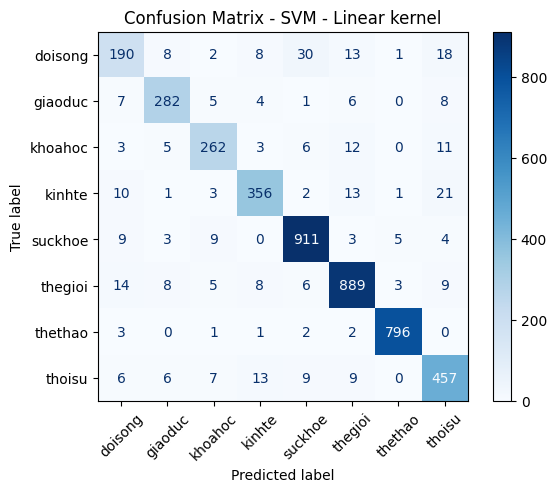

In [18]:
print("\n Confusion Matrix (Validation Set):")
cm_val_linear = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_linear, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - SVM - Linear kernel")


### Kernel rbf với C=1

In [19]:
print("- Training with kernel rbf ...")
print("- Train size = {}".format(X_train.shape))
model_rbf = svm.SVC(kernel='rbf', C=1)
model_rbf.fit(X_train, y_train)
print("- model - train complete")

- Training with kernel rbf ...
- Train size = (31745, 30910)
- model - train complete


In [20]:
print("- Testing with kernel rbf ...")
y_val_pred = model_rbf.predict(X_val)

print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

- Testing with kernel rbf ...

 Classification Report (Train Set):
              precision    recall  f1-score   support

     doisong       0.95      0.91      0.93      1585
     giaoduc       0.98      0.98      0.98      2180
     khoahoc       0.97      0.97      0.97      1991
      kinhte       0.97      0.97      0.97      3128
     suckhoe       0.98      0.99      0.99      6766
     thegioi       0.99      0.98      0.99      6823
     thethao       0.99      1.00      1.00      5710
      thoisu       0.97      0.97      0.97      3562

    accuracy                           0.98     31745
   macro avg       0.97      0.97      0.97     31745
weighted avg       0.98      0.98      0.98     31745



In [21]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


Classification Report (Validation Set):
              precision    recall  f1-score   support

     doisong       0.81      0.67      0.74       270
     giaoduc       0.91      0.90      0.90       313
     khoahoc       0.90      0.83      0.86       302
      kinhte       0.90      0.87      0.88       407
     suckhoe       0.94      0.97      0.96       944
     thegioi       0.93      0.95      0.94       942
     thethao       0.99      0.99      0.99       805
      thoisu       0.85      0.91      0.88       507

    accuracy                           0.92      4490
   macro avg       0.90      0.89      0.89      4490
weighted avg       0.92      0.92      0.92      4490




 Confusion Matrix (Validation Set):


Text(0.5, 1.0, 'Confusion Matrix - SVM - RBF kernel')

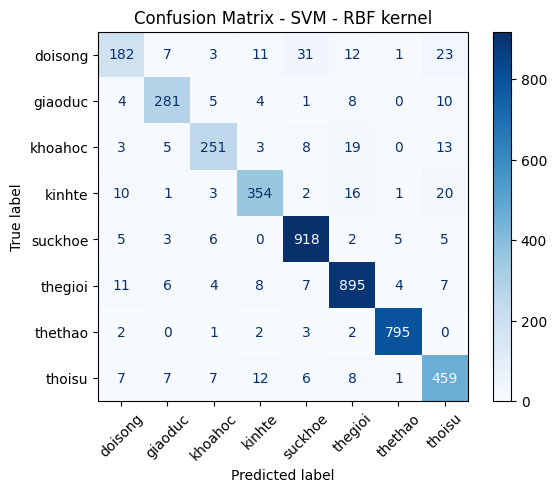

In [22]:
print("\n Confusion Matrix (Validation Set):")
cm_val_rbf = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_rbf, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - SVM - RBF kernel")

### Kernel poly với C=1

In [23]:
print("- Training with kernel poly ...")
print("- Train size = {}".format(X_train.shape))
model_poly = svm.SVC(kernel='poly', C=1)
model_poly.fit(X_train, y_train)
print("- model - train complete")

- Training with kernel poly ...
- Train size = (31745, 30910)


- model - train complete


In [24]:
print("- Testing with kernel poly ...")
y_val_pred = model_poly.predict(X_val)
print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

- Testing with kernel poly ...

 Classification Report (Train Set):
              precision    recall  f1-score   support

     doisong       0.95      0.91      0.93      1585
     giaoduc       0.98      0.98      0.98      2180
     khoahoc       0.97      0.97      0.97      1991
      kinhte       0.97      0.97      0.97      3128
     suckhoe       0.98      0.99      0.99      6766
     thegioi       0.99      0.98      0.99      6823
     thethao       0.99      1.00      1.00      5710
      thoisu       0.97      0.97      0.97      3562

    accuracy                           0.98     31745
   macro avg       0.97      0.97      0.97     31745
weighted avg       0.98      0.98      0.98     31745



In [25]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


Classification Report (Validation Set):
              precision    recall  f1-score   support

     doisong       1.00      0.03      0.06       270
     giaoduc       0.99      0.58      0.73       313
     khoahoc       0.93      0.22      0.35       302
      kinhte       0.94      0.64      0.76       407
     suckhoe       0.76      0.99      0.86       944
     thegioi       0.60      0.98      0.75       942
     thethao       0.98      0.97      0.98       805
      thoisu       0.93      0.73      0.82       507

    accuracy                           0.78      4490
   macro avg       0.89      0.64      0.66      4490
weighted avg       0.84      0.78      0.75      4490




 Confusion Matrix (Validation Set):


Text(0.5, 1.0, 'Confusion Matrix - SVM - polypoly kernel')

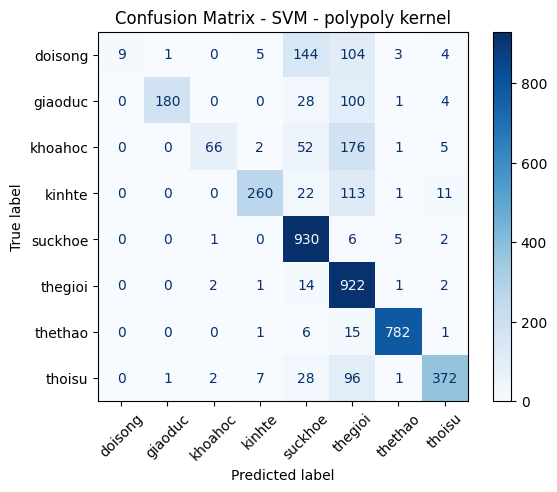

In [26]:
print("\n Confusion Matrix (Validation Set):")
cm_val_poly = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_poly, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - SVM - polypoly kernel")

### Kernel sigmoid với C=1

In [27]:
print("- Training with kernel sigmoid ...")
print("- Train size = {}".format(X_train.shape))
model_sigmoid = svm.SVC(kernel='sigmoid', C=1)
model_sigmoid.fit(X_train, y_train)
print("- model - train complete")


- Training with kernel sigmoid ...
- Train size = (31745, 30910)
- model - train complete


In [28]:
print("- Testing with kernel sigmoid ...")
y_val_pred = model_sigmoid.predict(X_val)
print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

- Testing with kernel sigmoid ...

 Classification Report (Train Set):
              precision    recall  f1-score   support

     doisong       0.95      0.91      0.93      1585
     giaoduc       0.98      0.98      0.98      2180
     khoahoc       0.97      0.97      0.97      1991
      kinhte       0.97      0.97      0.97      3128
     suckhoe       0.98      0.99      0.99      6766
     thegioi       0.99      0.98      0.99      6823
     thethao       0.99      1.00      1.00      5710
      thoisu       0.97      0.97      0.97      3562

    accuracy                           0.98     31745
   macro avg       0.97      0.97      0.97     31745
weighted avg       0.98      0.98      0.98     31745



In [29]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


Classification Report (Validation Set):
              precision    recall  f1-score   support

     doisong       0.78      0.69      0.73       270
     giaoduc       0.90      0.90      0.90       313
     khoahoc       0.89      0.86      0.88       302
      kinhte       0.89      0.88      0.89       407
     suckhoe       0.94      0.96      0.95       944
     thegioi       0.94      0.94      0.94       942
     thethao       0.99      0.99      0.99       805
      thoisu       0.86      0.90      0.88       507

    accuracy                           0.92      4490
   macro avg       0.90      0.89      0.89      4490
weighted avg       0.92      0.92      0.92      4490




 Confusion Matrix (Validation Set):


Text(0.5, 1.0, 'Confusion Matrix - SVM - Sigmoid kernel')

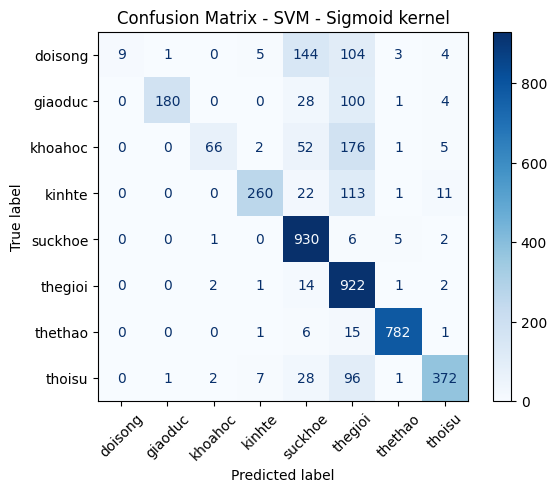

In [30]:
print("\n Confusion Matrix (Validation Set):")
cm_val_sigmoid = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_poly, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - SVM - Sigmoid kernel")

### Thực hiện sử dụng model đã được train để infer 1 văn bản mới 

In [31]:
new_doc = "Lạm phát tăng cao gây áp lực lên giá xăng và thực phẩm"
#Xóa stopwords
new_doc = preprocess(new_doc)

#Tokenize
tokenized_new_doc = ViTokenizer.tokenize(new_doc)
tokenized_new_doc = [tokenized_new_doc]
print(tokenized_new_doc)

input_data_preprocessed = vectorizer.transform(tokenized_new_doc)
print(input_data_preprocessed)

['Lạm_phát áp_lực giá xăng_thực_phẩm']
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 30910)>
  Coords	Values
  (0, 8529)	0.45478420948974574
  (0, 14137)	0.6779852363694497
  (0, 29238)	0.5775009455090515


### Dự đoán nhãn của văn bản trên

In [34]:
prediction = model_rbf.predict(input_data_preprocessed)
predicted_label = prediction[0]
predicted_category = le.inverse_transform([predicted_label])[0]
print(f"Predicted label index: {predicted_label}")
print(f"Predicted category: {predicted_category}")

Predicted label index: 3
Predicted category: kinhte


## 4. Tối ưu tham số

*Lưu ý: tối ưu tham số trên tập validation, sau đó cuối cùng lấy tham số tốt nhất đánh giá cho tập test* 

## 5. Tài liệu tham khảo

- Dataset: https://www.kaggle.com/datasets/dat111/xlnntn-th-lab08
- Vietnamese stopwords: https://github.com/stopwords/vietnamese-stopwords  
- Thư viện preprocessing tiếng Việt: pyvi - https://pypi.org/project/pyvi/